In [1]:
%matplotlib notebook
import numpy as np
import cv2
import rasterio as rio
import matplotlib.pyplot as plt

In [2]:
# Read and visualize sentinel data - band 4

band4 = rio.open('S2B_MSIL1C_20170831T095029_N0205_R079_T33UYS_20170831T095023.SAFE/GRANULE/L1C_T33UYS_A002536_20170831T095023/IMG_DATA/T33UYS_20170831T095029_B04.jp2')
band3 = rio.open('S2B_MSIL1C_20170831T095029_N0205_R079_T33UYS_20170831T095023.SAFE/GRANULE/L1C_T33UYS_A002536_20170831T095023/IMG_DATA/T33UYS_20170831T095029_B03.jp2')
band2 = rio.open('S2B_MSIL1C_20170831T095029_N0205_R079_T33UYS_20170831T095023.SAFE/GRANULE/L1C_T33UYS_A002536_20170831T095023/IMG_DATA/T33UYS_20170831T095029_B02.jp2')

In [3]:
def prepare_plot(red, green, blue, hist_eq='global'):
    """
    Function prepares EO data for plotting (multi-channel data)
    red = Band 4 of Sentinel 2
    green = Band 3 of Sentinel 2
    blue = Band 2 of Sentinel 2
    hist_eq = Histogram equalization technique from OpenCV:
                global = global histogram equalization
                local = local histogram equalization
                None = no equalization
    output = numpy.ndarray of dimensions (width, height, layer)
    """
    
    r = (red.read()[0]/65535 * 255).astype(np.uint8)
    g = (green.read()[0]/65535 * 255).astype(np.uint8)
    b = (blue.read()[0]/65535 * 255).astype(np.uint8)
    
    if hist_eq == 'global':
        r = cv2.equalizeHist(r)
        g = cv2.equalizeHist(g)
        b = cv2.equalizeHist(b)
    elif hist_eq == 'local':
        clahe = cv2.createCLAHE(clipLimit=32.0, tileGridSize=(64,64))
        r = clahe.apply(r)
        g = clahe.apply(g)
        b = clahe.apply(b)
    elif hist_eq == None:
        pass
    else:
        raise ValueError('You should provide three values: "global", "local" or None. Default is "global".')
        
    output = np.dstack((r, g, b))
    return output

<IPython.core.display.Javascript object>


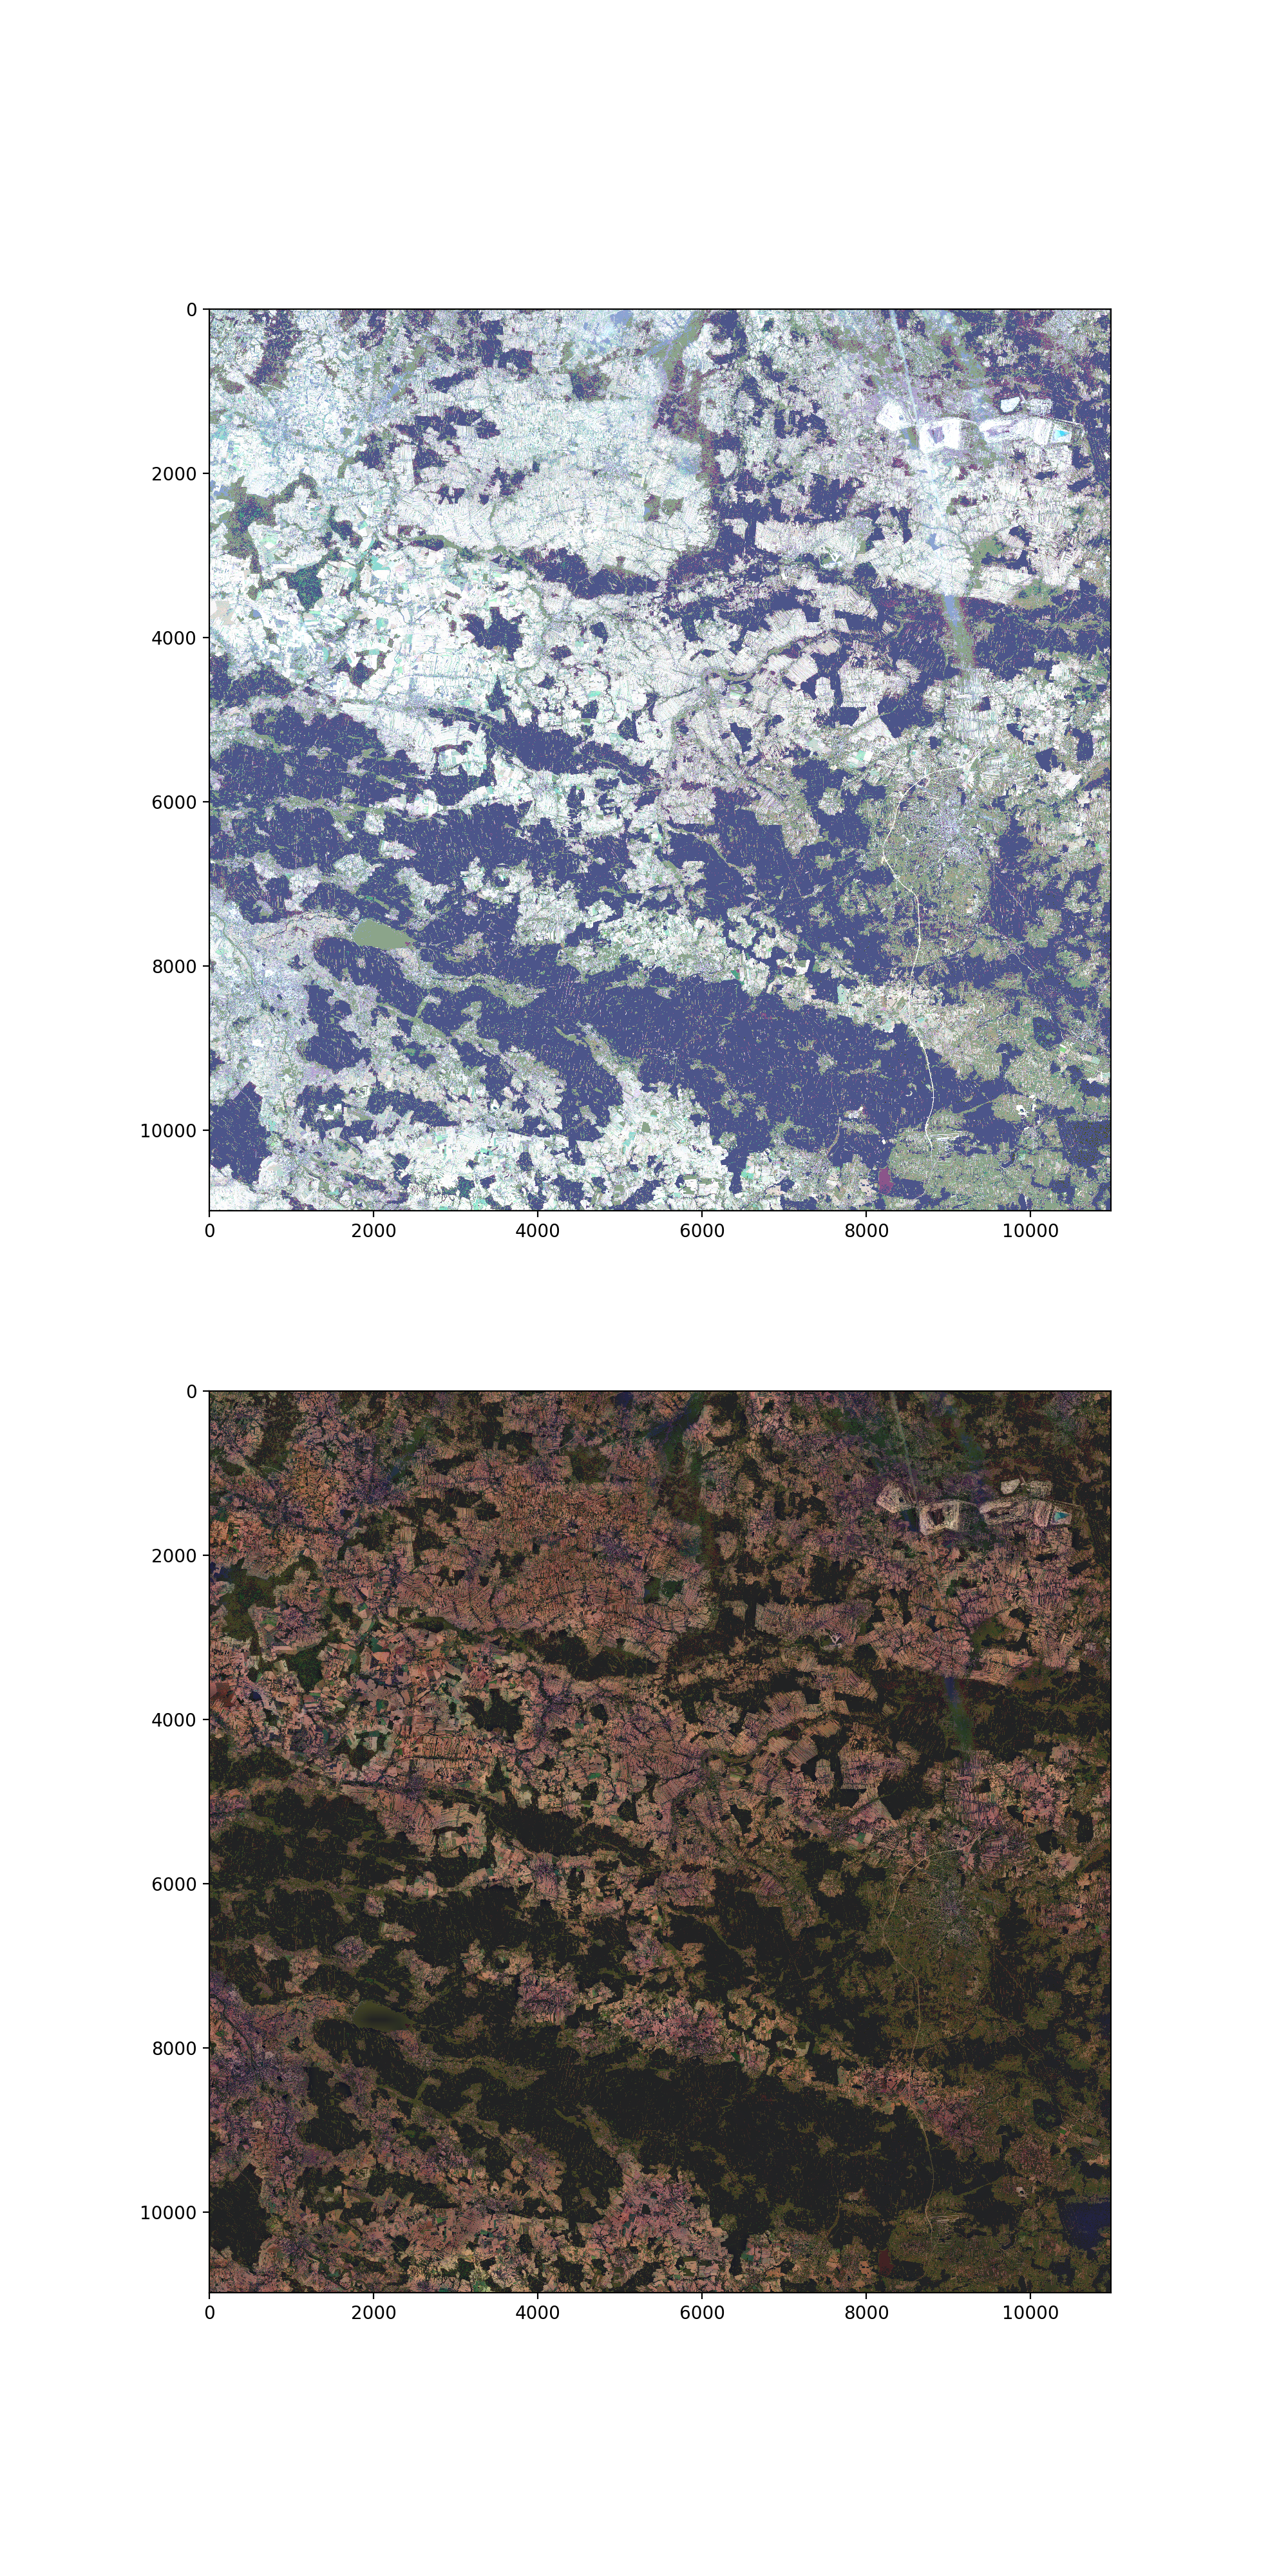

In [4]:
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(211)
ax1.imshow(prepare_plot(band4, band3, band2, 'global'))

ax2 = fig.add_subplot(212)
ax2.imshow(prepare_plot(band4, band3, band2, 'local'))
plt.show()

In [7]:
band8 = rio.open('S2B_MSIL1C_20170831T095029_N0205_R079_T33UYS_20170831T095023.SAFE/GRANULE/L1C_T33UYS_A002536_20170831T095023/IMG_DATA/T33UYS_20170831T095029_B08.jp2')

In [8]:
def ndwi(sentinel_band_3, sentinel_band_8):
    ndwi_up = (sentinel_band_3 - sentinel_band_8)
    ndwi_down = (sentinel_band_3 + sentinel_band_8)
    ndwi = np.zeros(sentinel_band_3.shape)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        ndwi = ndwi_up / ndwi_down
        ndwi = np.nan_to_num(ndwi)
        ndwi[ndwi > 1] = 0
    return ndwi

In [9]:
water_index = ndwi(band3.read(), band8.read())

In [10]:
np.max(water_index)

0.69642337888921202

In [9]:
print(np.std(water_index[water_index > 0]), np.mean(water_index[water_index > 0]))

0.118242673286 0.194498857128


In [10]:
water_index[0].shape

(10980, 10980)

<IPython.core.display.Javascript object>


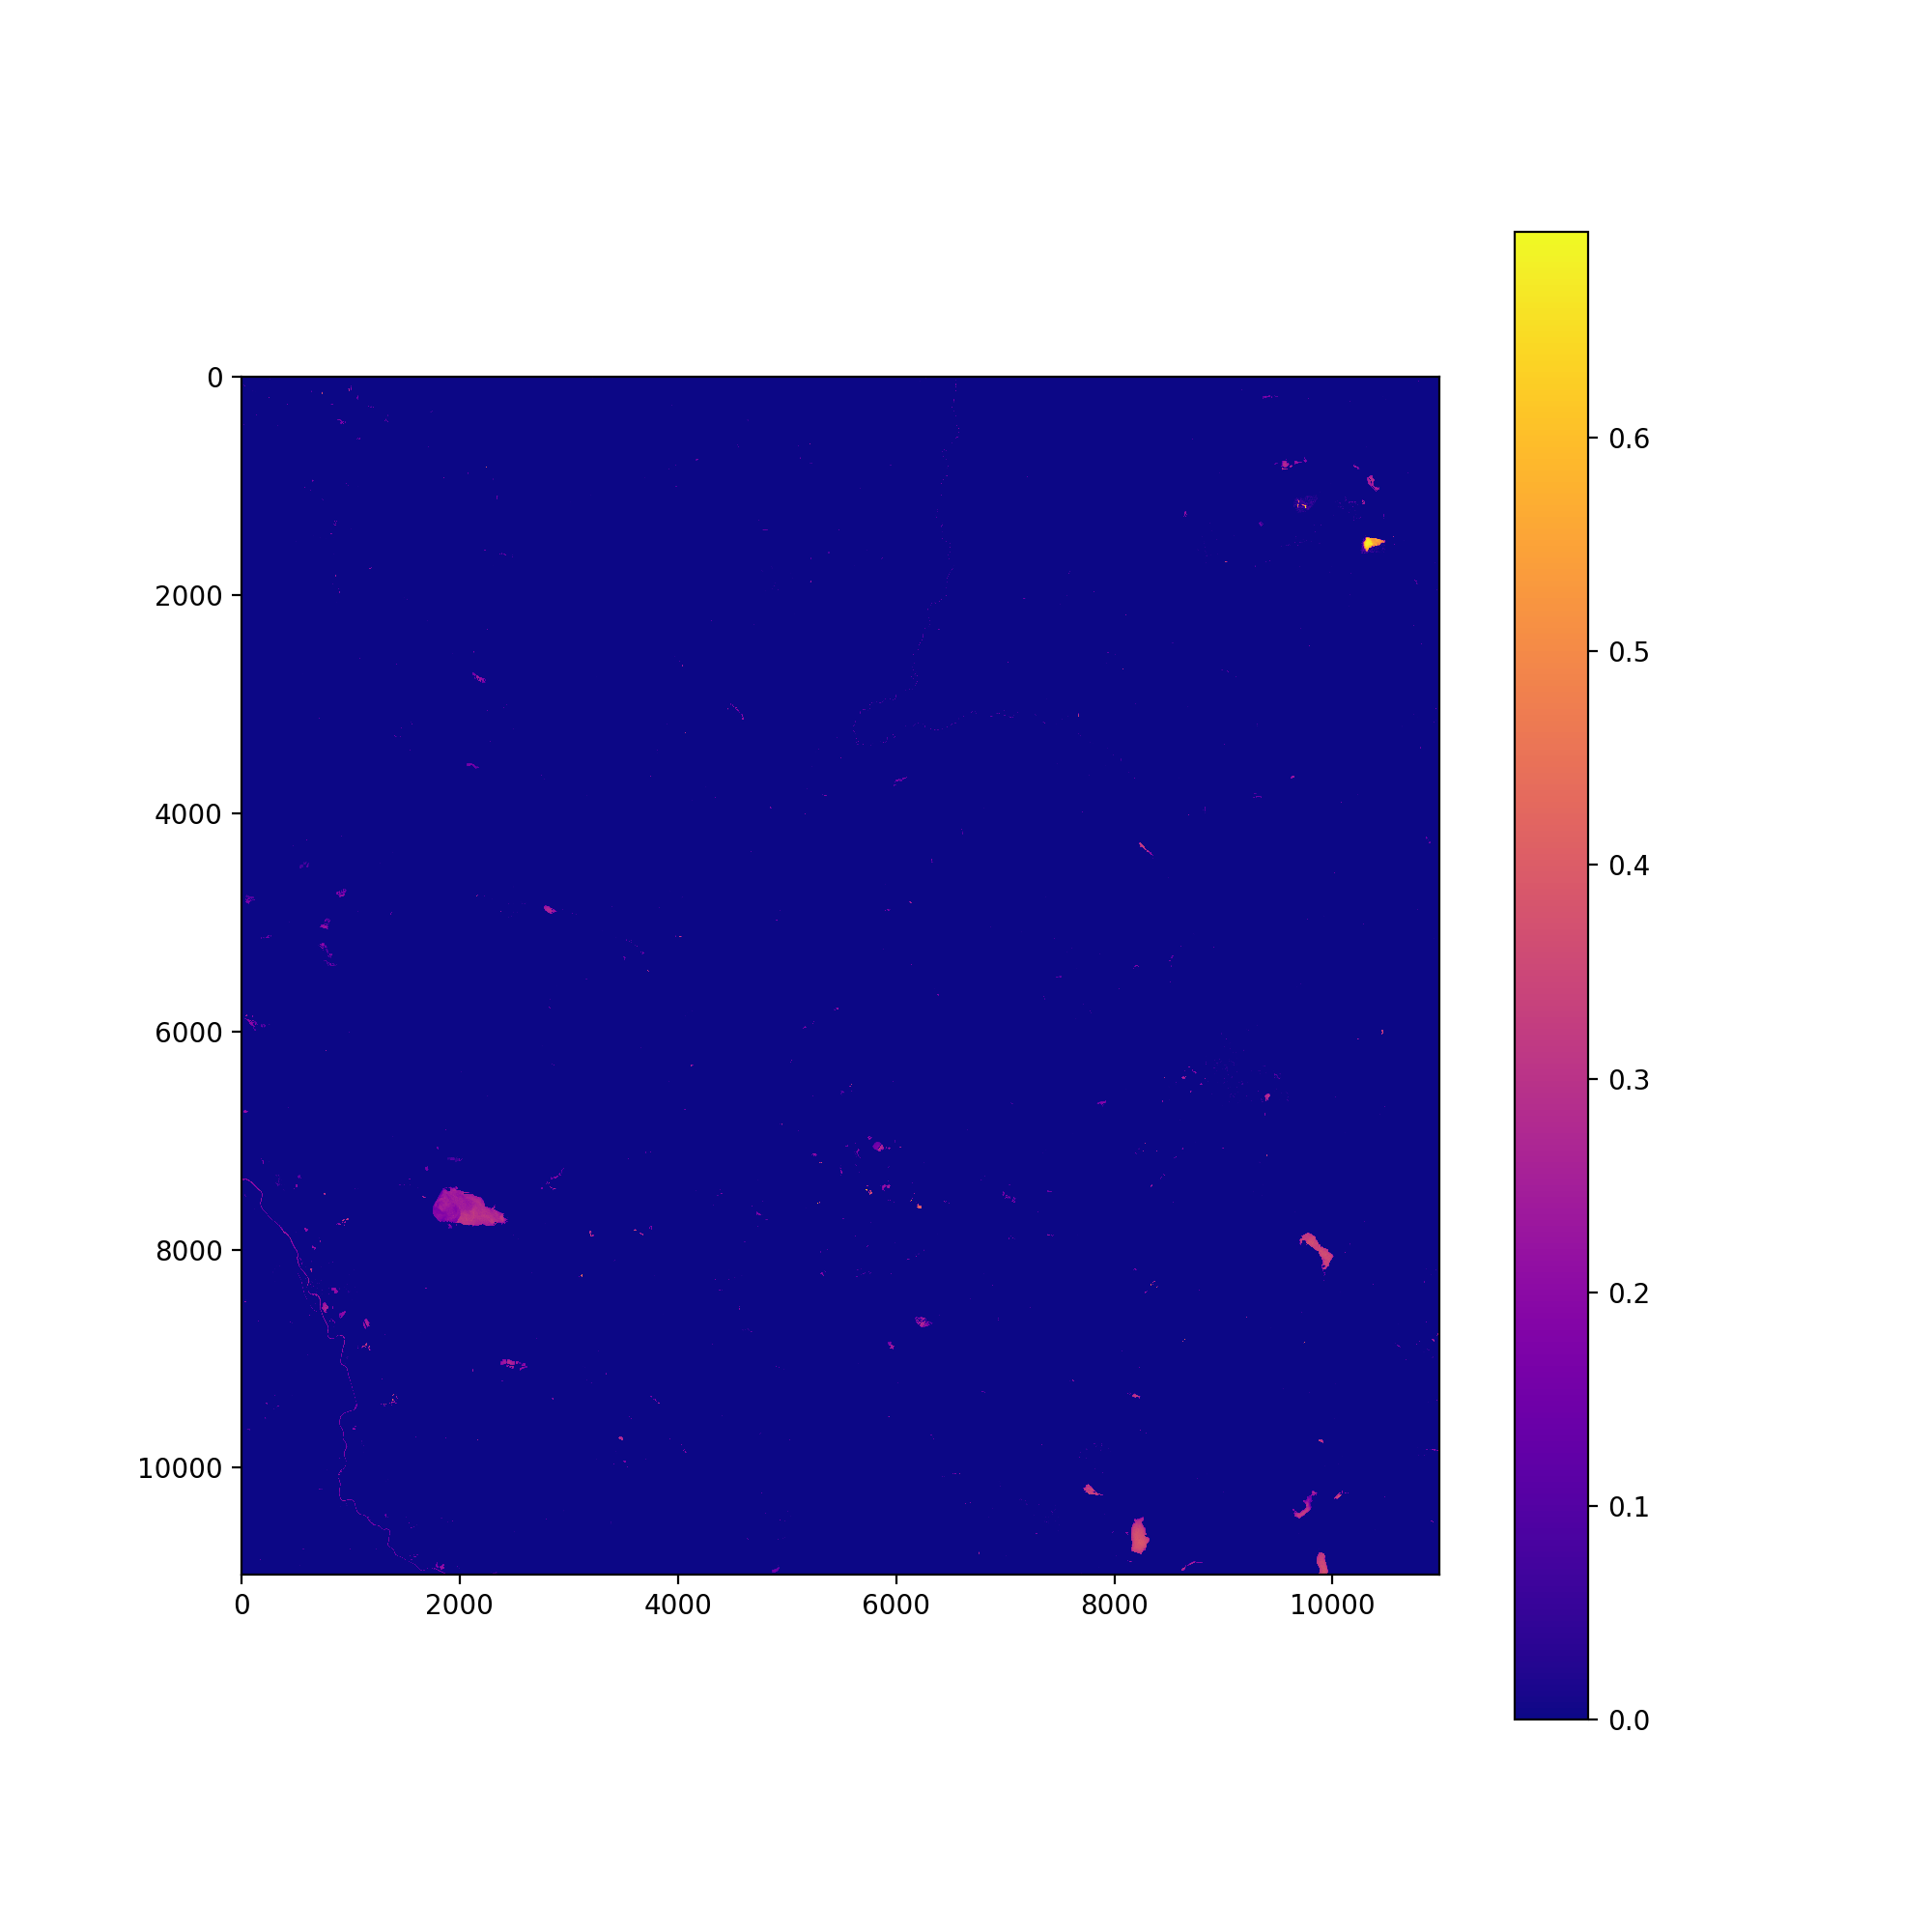

In [11]:
plt.figure(figsize=(10,10))
imgplot = plt.imshow(water_index[0])
imgplot.set_cmap('plasma')  # better color schemes: viridis, plasma, PRGn
plt.colorbar()

<IPython.core.display.Javascript object>


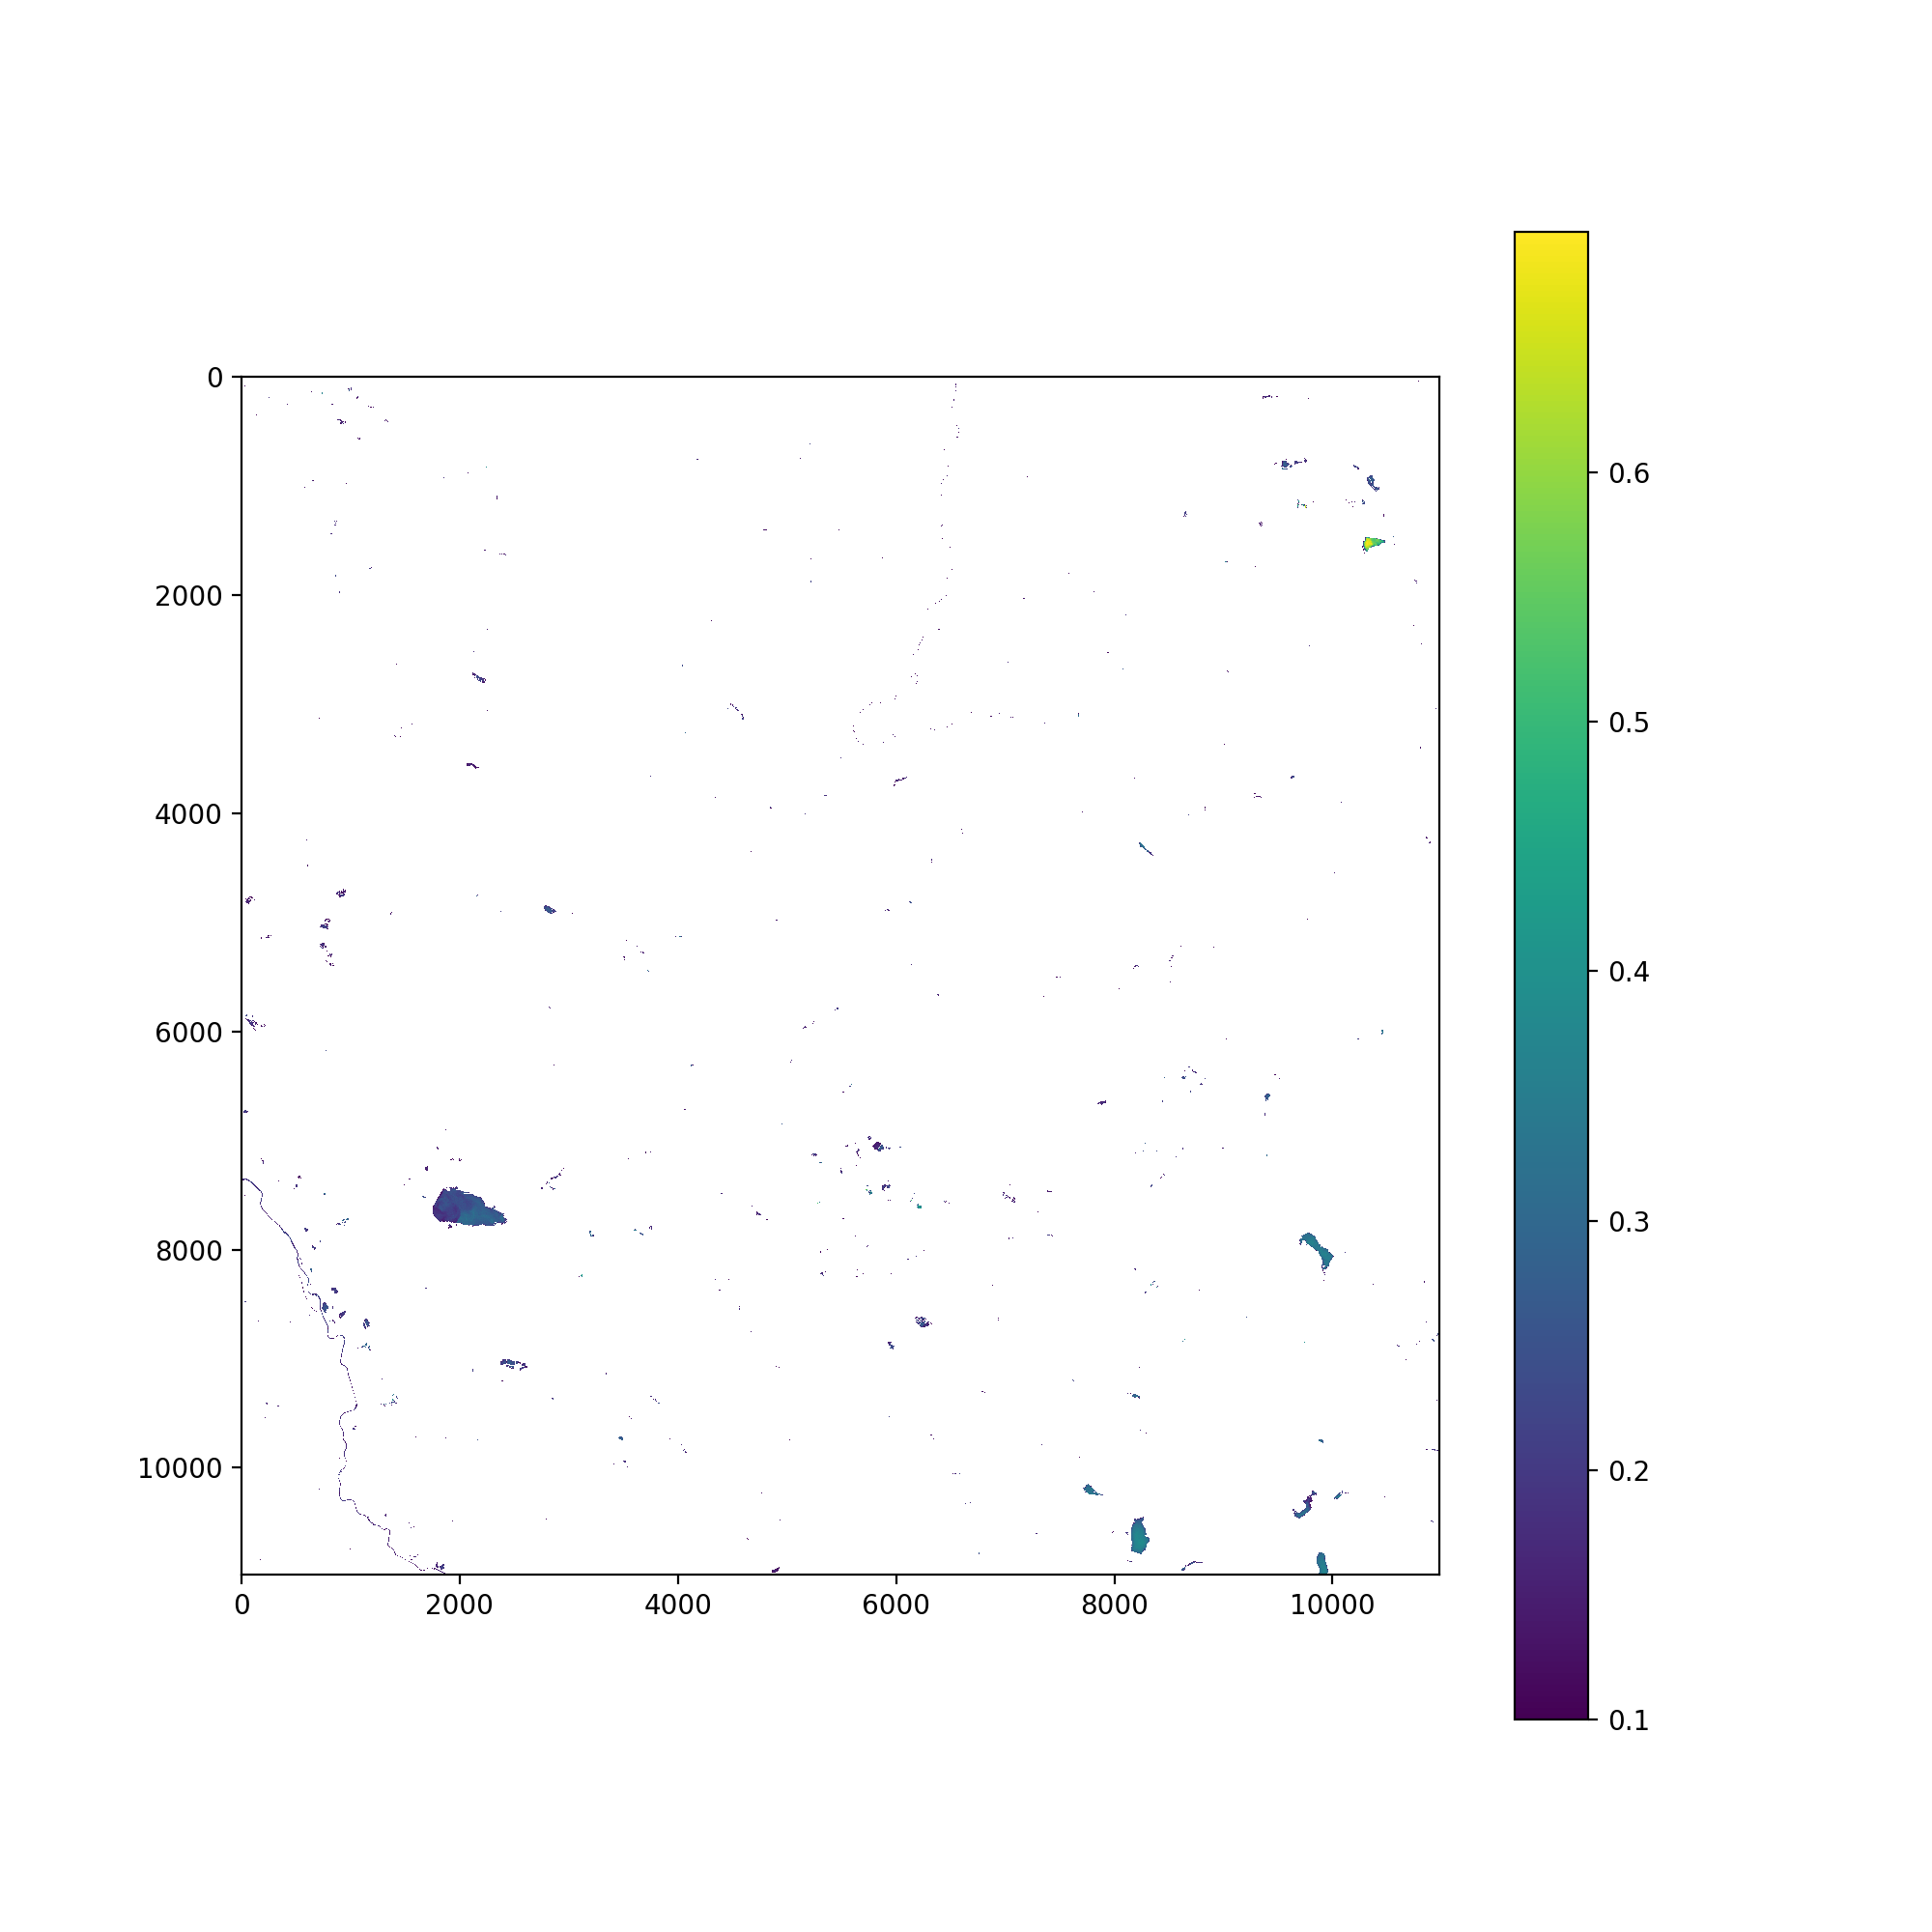

In [12]:
plt.figure(figsize=(10,10))
new_idx = water_index[0]
new_idx[new_idx < 0.1] = np.nan
imgplot = plt.imshow(new_idx)
imgplot.set_cmap('viridis')  # better color schemes: viridis, plasma, PRGn
plt.colorbar()